In [1]:
# Imports
from Code.h5Constructor import h5Constructor
import cProfile

In [2]:
#gc = h5Constructor('./Dataset/CIFs/Simulated/', './Dataset/h5/Simulated/')
# cProfile.run('gc.gen_h5s(parallelize=False, device="cuda")', sort='tottime')
#gc.gen_h5s(parallelize=False, device='cuda')

Save directory doesn't exist.
Created the save directory at Dataset/h5/Simulated

Constructing graphs from cif files:


0it [00:00, ?it/s]

In [1]:
from Code.datasetClass import InOrgMatDatasets
from pathlib import Path

test = InOrgMatDatasets('Simulated', root='./Dataset/')

In [2]:
test.create_data_split()
test.create_data_split(split_strategy='stratified', stratify_on='Crystal type')

/home/ufj/anaconda3/envs/dataset_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/ufj/anaconda3/envs/dataset_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [3]:
test.load_data_split(split_strategy='stratified', stratify_on='Crystal type')

In [4]:
test.get(1)

Data(
  x=[3, 4],
  edge_index=[2, 4],
  edge_attr=[6],
  y={
    crystal_type='CdI2',
    space_group_symbol='C 2/m',
    space_group_number=12,
    atomic_species=[2],
    n_atomic_species=2,
    cell_params=[6],
    np_size=23.166933059692383,
    nd=[2, 2900],
    xrd=[2, 2900],
    nPDF=[2, 3000],
    xPDF=[2, 3000],
    sans=[2, 300],
    saxs=[2, 300]
  },
  pos=[3, 3],
  pos_real=[3, 3]
)

In [7]:
test.get(1, split='test')

Data(
  x=[12, 4],
  edge_index=[2, 64],
  edge_attr=[88],
  y={
    crystal_type='Fluorite',
    space_group_symbol='F m -3 m',
    space_group_number=225,
    atomic_species=[2],
    n_atomic_species=2,
    cell_params=[6],
    np_size=57.49021911621094,
    nd=[2, 2900],
    xrd=[2, 2900],
    nPDF=[2, 3000],
    xPDF=[2, 3000],
    sans=[2, 300],
    saxs=[2, 300]
  },
  pos=[12, 3],
  pos_real=[12, 3]
)

In [5]:
stats = test.get_statistics(return_dataframe=True)
stats.head()

,idx,# of nodes,# of edges,# of elements,Space group (Symbol),Space group (Number),Crystal type,NP size (Å),Elements,Random data split,Stratified data split (Crystal type)
0,0,3.0,4.0,2.0,C 2/m,12.0,CdI2,13.340669,"[tensor(8.), tensor(26.)]",Train,Train
1,1,3.0,4.0,2.0,C 2/m,12.0,CdI2,23.166933,"[tensor(8.), tensor(26.)]",Train,Validation
2,2,3.0,4.0,2.0,C 2/m,12.0,CdI2,33.122952,"[tensor(8.), tensor(26.)]",Train,Train
3,3,3.0,4.0,2.0,C 2/m,12.0,CdI2,43.287453,"[tensor(8.), tensor(26.)]",Train,Validation
4,4,3.0,4.0,2.0,C 2/m,12.0,CdI2,53.547028,"[tensor(8.), tensor(26.)]",Validation,Train


In [6]:
stats.describe()

,# of nodes,# of edges,# of elements,Space group (Number),NP size (Å)
count,200.000000,200.000000,200.0,200.00000,200.000000
mean,13.125000,55.250000,2.0,163.37500,33.689808
std,16.575073,79.457567,0.0,85.83749,14.623227
min,3.000000,4.000000,2.0,12.00000,9.680614
25%,4.000000,7.500000,2.0,111.00000,22.610600
50%,7.000000,20.000000,2.0,223.00000,33.424063
75%,12.000000,64.000000,2.0,225.00000,43.926042
max,56.000000,256.000000,2.0,227.00000,57.490219


In [7]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

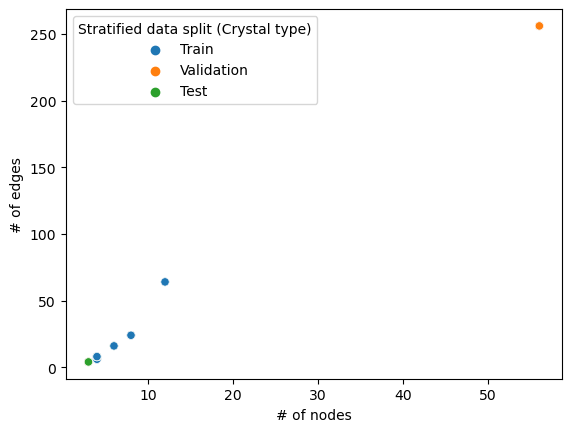

In [9]:
sns.scatterplot(data=stats, x='# of nodes', y='# of edges', hue='Stratified data split (Crystal type)')
plt.show()

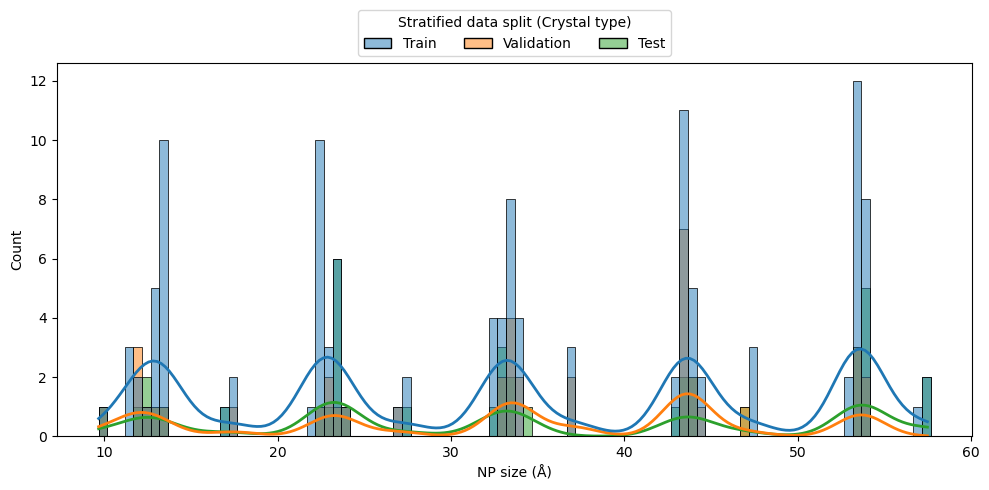

In [10]:
plt.figure(figsize=(10,5))
ax = sns.histplot(data=stats, x='NP size (Å)', binwidth=0.5, hue='Stratified data split (Crystal type)', multiple='layer',kde=True, kde_kws=dict(bw_method=0.1), line_kws=dict(linewidth=2), stat='count')
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
plt.savefig('./test_stats_sizeDist.png', format='png', dpi=300)
plt.show()

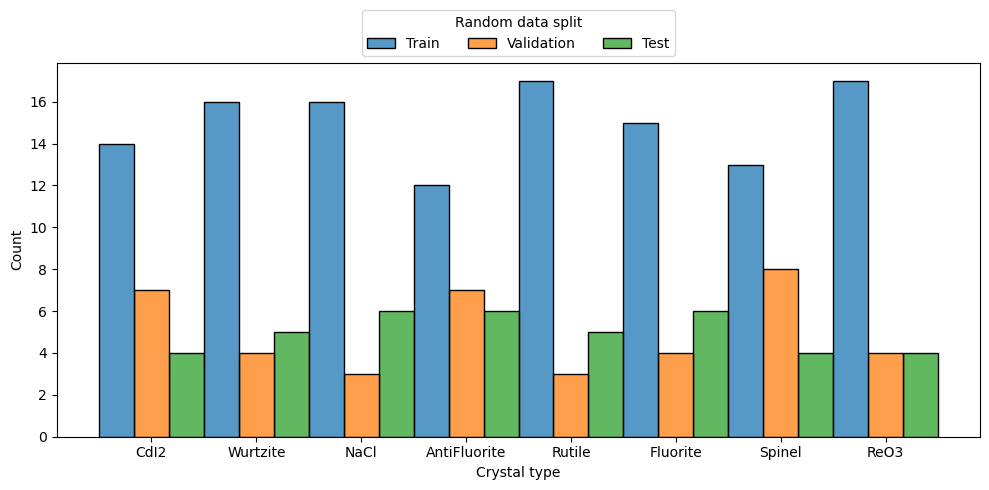

In [14]:
plt.figure(figsize=(10,5))
ax = sns.histplot(data=stats, x='Crystal type', hue='Random data split', multiple='dodge')
#ax = sns.histplot(data=stats, x='Crystal type', hue='Stratified data split (Crystal type)', multiple='dodge')
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
plt.savefig('./test_stats_crystalTypes.png', format='png', dpi=300)
plt.show()

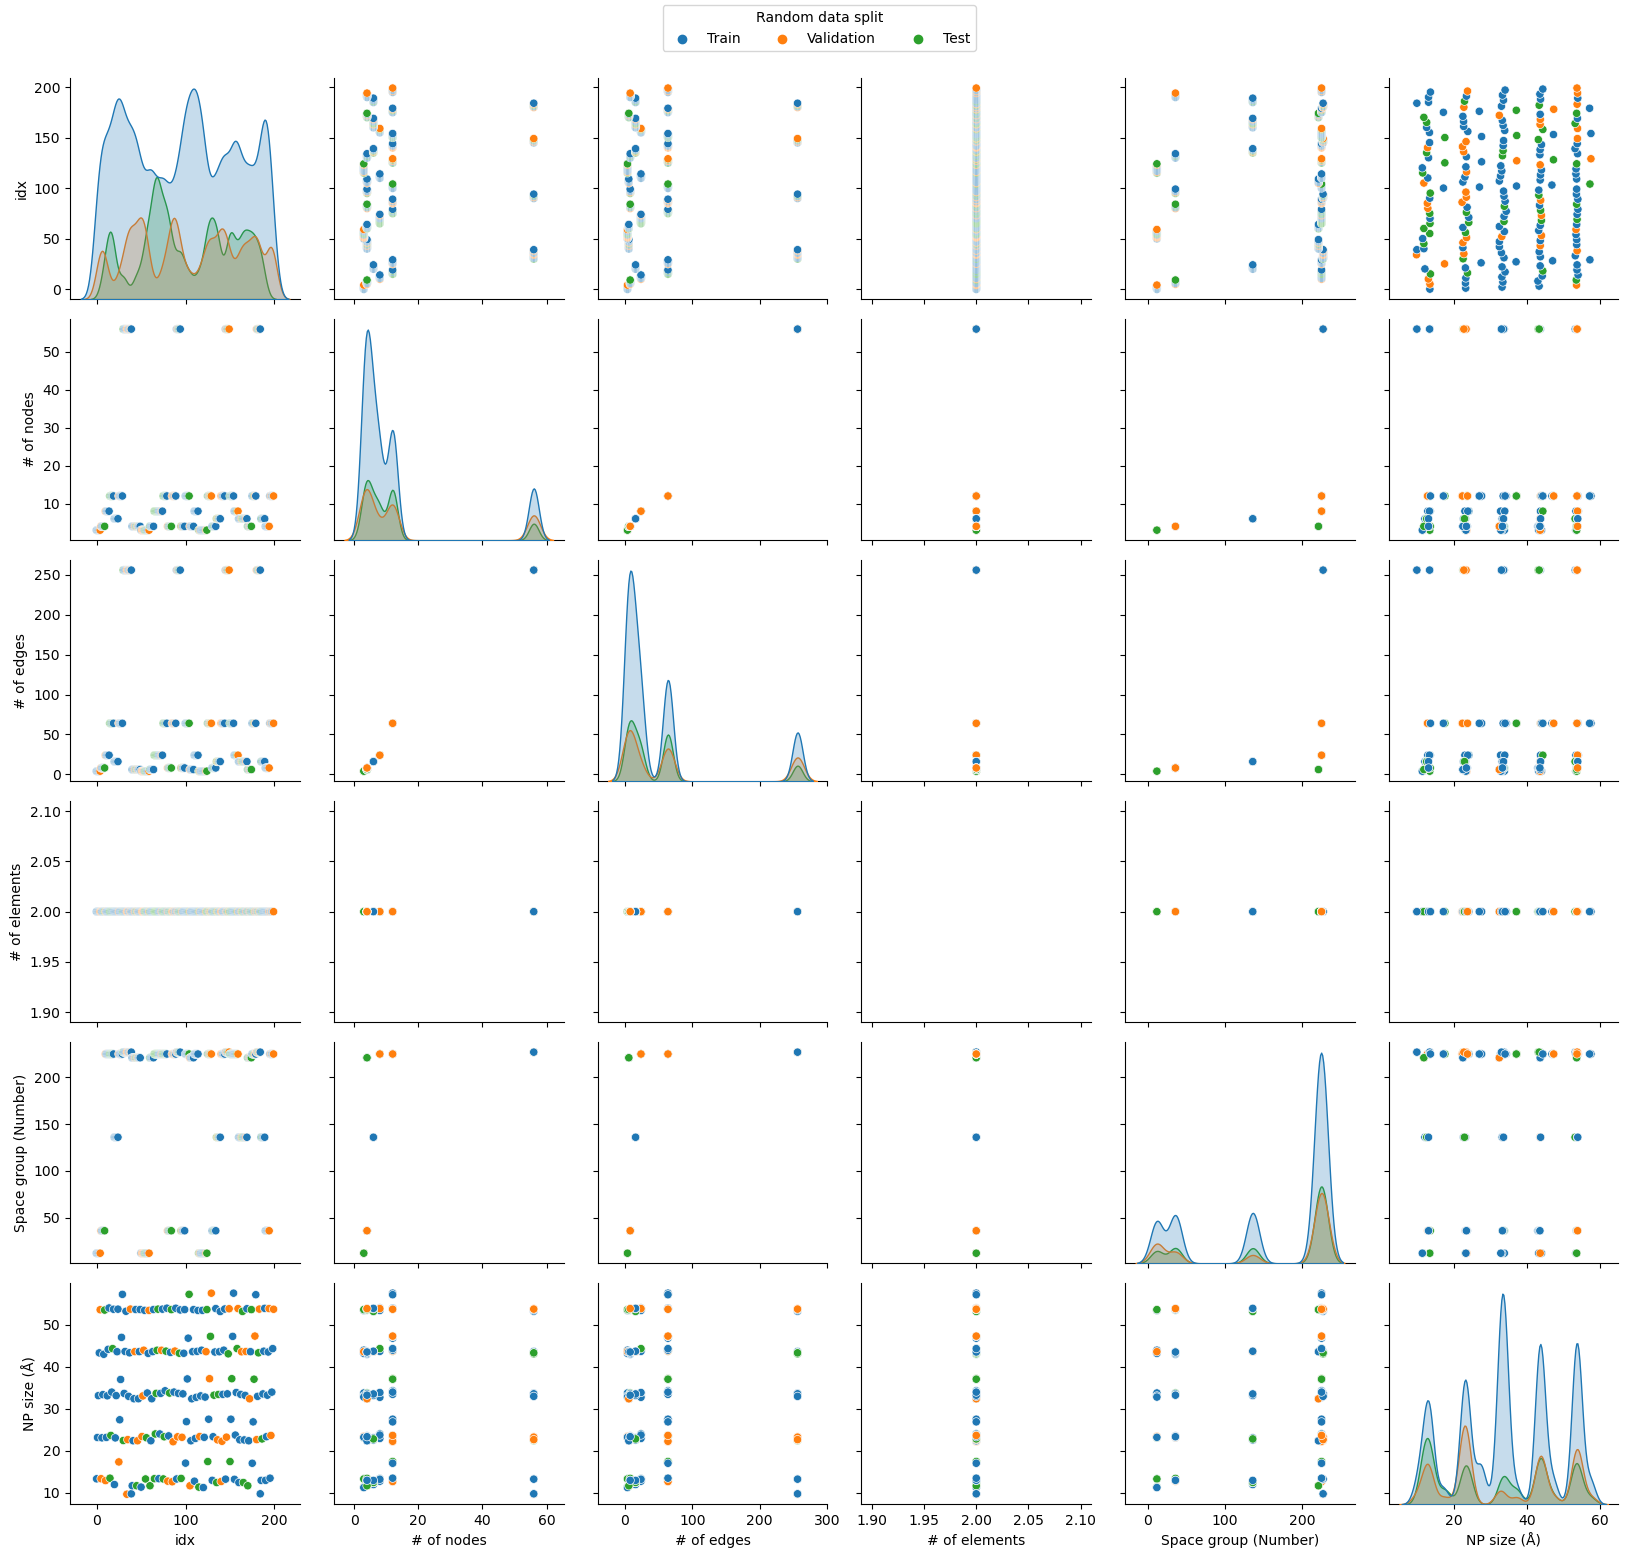

In [12]:
ax = sns.pairplot(data=stats, hue='Random data split', diag_kws=dict(bw_method=0.1))
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
plt.savefig('./test_stats_pairplot.png', format='png', dpi=300)
plt.show()

In [13]:
stats.columns

Index(['idx', '# of nodes', '# of edges', '# of elements',
       'Space group (Symbol)', 'Space group (Number)', 'Crystal type',
       'NP size (Å)', 'Elements', 'Random data split',
       'Stratified data split (Crystal type)'],
      dtype='object')

In [13]:
#import Code.cifCleaning as cc
#import pandas as pd

#df = cc.cif_cleaning_pipeline('./Dataset/CIFs/ICSD_MonoMetalOxides/', remove_duplicates=True, unwanted_atoms=None, chunksize=1000)